# **Тематическое моделирование сообщений с форума Reddit с помощью библиотеки BERTopic**

Этот проект позволяет:
1. Получить данные из Reddit
2. Очистить полученные данные
3. Провести тематическое моделирование
4. Сохранить результат в локальную базу данных SQLite 

Проект можно подстраивать под другие источники информации, что позволяет проводить разные эксперименты.

## Загрузка данных из Reddit:

### Импорт библиотек:

In [1]:
import praw
from praw.models import MoreComments
from datetime import datetime, timedelta
import configparser
import time

### Инициализация Reddit API:

In [2]:
config = configparser.ConfigParser()
config.read("/home/bellap/topic_modelling/config.ini")

['/home/bellap/topic_modelling/config.ini']

In [3]:
reddit = praw.Reddit(
    client_id=config.get("reddit", "client_id"),
    client_secret=config.get("reddit", "client_secret"),
    user_agent=config.get("reddit", "user_agent"),
    check_for_async=False,
)

### Выбор ветки форума:

In [4]:
subreddit = reddit.subreddit("politics")

### Загрузка комментариев из последних тем:

In [5]:
comms = []

# Проходим по всем новым темам
for submission in subreddit.new(limit=None):  # ограничиваем количество тем для анализа
    # Проверяем, что тема была создана за последние 24 часа
    if submission.created_utc > time.time() - 24 * 60 * 60:
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            comms.append(comment.body)

### Вывод первых результатов:

In [6]:
from pprint import pprint

In [7]:
len(comms)

10977

## Предобработка текста:

### Импорт библиотек:

In [8]:
import spacy
import re

Отключим ненужные шаги в пайплайне spaCy.

In [9]:
nlp = spacy.load(
    "en_core_web_lg",
    exclude=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"],
)

### Функция очистки текста от html элементов с помощью Regex:

In [10]:
def regex_preprocessing(text):
    text = re.sub(
        r"\n|\r|\<.*?\>|\{.*?\}|\[.*?\]|u/|\(.*emote.*\)|\[gif\]|_", " ", text
    )
    text = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        " ",
        text,
    )
    return text

#### Проверка Regex:

In [11]:
import pytest

In [12]:
def test_regex_preprocessing():
    # Тесты на проверку удаления URL
    text = "Проверьте это:https://example.com"
    assert regex_preprocessing(text) == "Проверьте это: "

    text = "Проверьте это:http://example10.ru"
    assert regex_preprocessing(text) == "Проверьте это: "

    # Тесты на проверку удаления тегов
    text = "Привет, <имя пользователя>"
    assert regex_preprocessing(text) == "Привет,  "

    text = "Привет, [слово1]"
    assert regex_preprocessing(text) == "Привет,  "

    text = "Привет, {идея*}"
    assert regex_preprocessing(text) == "Привет,  "

    # Тесты на проверку удаления символов новой строки и символов профиля Reddit
    text = "\rПривет, как дела?"
    assert regex_preprocessing(text) == " Привет, как дела?"

    text = "Привет,\nкак дела?"
    assert regex_preprocessing(text) == "Привет, как дела?"

    text = "Привет, как дела,u/danny?"
    assert regex_preprocessing(text) == "Привет, как дела, danny?"

    # Тесты на проверку удаления специальных символов
    text = "Привет![gif]"
    assert regex_preprocessing(text) == "Привет! "

    text = "Привет!(emote emote-hello)"
    assert regex_preprocessing(text) == "Привет! "


# Запуск тестов
test_regex_preprocessing()

### Функция для подготовки текста к моделированию:

BERTopic использует трансформеры. Модель лучше обучается, если получает большую информацию из текста. Поэтому, предобработка минимальная.

In [13]:
def tokenizer_preprocessing(text_list):
    texts = []
    for text in text_list:
        doc = nlp(text)
        tokens = [token.text.lower() for token in doc]
        tokens = " ".join(tokens)
        tokens = re.sub(r"[^\w0-9'’]", " ", tokens)
        tokens = tokens.split()
        tokens = [token for token in tokens if not token.isspace()]
        tokens = " ".join(tokens)
        texts.append(tokens)
    return texts

#### Проверка Regex:

In [14]:
def test_tokenizer_preprocessing():
    # Тест на проверку удаления лишних символов
    text = "*I don't remember summer 1992, it’s so-so far away&"
    text = re.sub(r"[^\w0-9'’ ]", " ", text)
    assert text == " I don't remember summer 1992  it’s so so far away "


# Запуск теста
test_tokenizer_preprocessing()

### Удалим дубликаты и документы, в которых меньше трех слов:

In [15]:
import pandas as pd

In [16]:
comms_data = pd.DataFrame(data=comms, columns=["comments"]).drop_duplicates(
    subset="comments", keep=False
)
comms_data = comms_data[comms_data["comments"].str.split().str.len() > 3]

In [17]:
pprint(comms_data["comments"].to_list()[:4])

["This is Republicans saying that Biden needs to threaten Iran. I'm sure their "
 'advice is totally in good faith\xa0',
 'Biden says counties that have been attacked have a right to defend '
 'themselves.',
 "But they're cool with Russia invading a sovereign nation to conquer "
 'landmass.',
 'Good.\n'
 '\n'
 'I expect to do a background check when I buy a firearm.  And there should be '
 'NO way for me to get around that.\n'
 '\n'
 'I even think it should be required for private transfers between family '
 'members, too.']


### Применим функции для предобработки текста для BERTopic:

In [18]:
clean_data = comms_data["comments"].apply(regex_preprocessing).to_list()
clean_data[:4]

["This is Republicans saying that Biden needs to threaten Iran. I'm sure their advice is totally in good faith\xa0",
 'Biden says counties that have been attacked have a right to defend themselves.',
 "But they're cool with Russia invading a sovereign nation to conquer landmass.",
 'Good.  I expect to do a background check when I buy a firearm.  And there should be NO way for me to get around that.  I even think it should be required for private transfers between family members, too.']

In [19]:
clean_data = tokenizer_preprocessing(clean_data)
clean_data[:4]

["this is republicans saying that biden needs to threaten iran i 'm sure their advice is totally in good faith",
 'biden says counties that have been attacked have a right to defend themselves',
 "but they 're cool with russia invading a sovereign nation to conquer landmass",
 'good i expect to do a background check when i buy a firearm and there should be no way for me to get around that i even think it should be required for private transfers between family members too']

#### Размер корпуса для BERTopic:

In [20]:
len(clean_data)

10145

## BERTopic:

### Импорт библиотек:

In [21]:
from bertopic import BERTopic
from bertopic.representation import (
    KeyBERTInspired,
    MaximalMarginalRelevance,
    PartOfSpeech,
)

/home/bellap/topic_modelling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Настройка пайплайна BERTopic:

#### Векторное представление текстов:

Модель UAE-Large-V1 была выбрана с помощью бенчмарка от Hugging Face. Легкая, хорошо работает с данными из Reddit.

In [22]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("WhereIsAI/UAE-Large-V1")
embeddings = embedding_model.encode(clean_data, show_progress_bar=True)

Batches: 100%|██████████| 318/318 [02:38<00:00,  2.00it/s]


#### Уменьшим размерность векторов с помощью Uniform Manifold Approximation and Projection (UMAP):

In [23]:
from umap import UMAP

#### Визуализация применения UMAP для наших данных:

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")

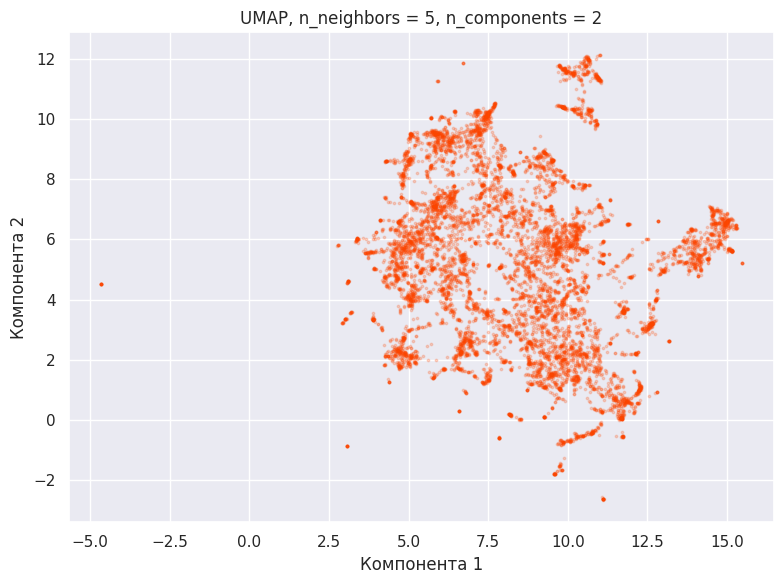

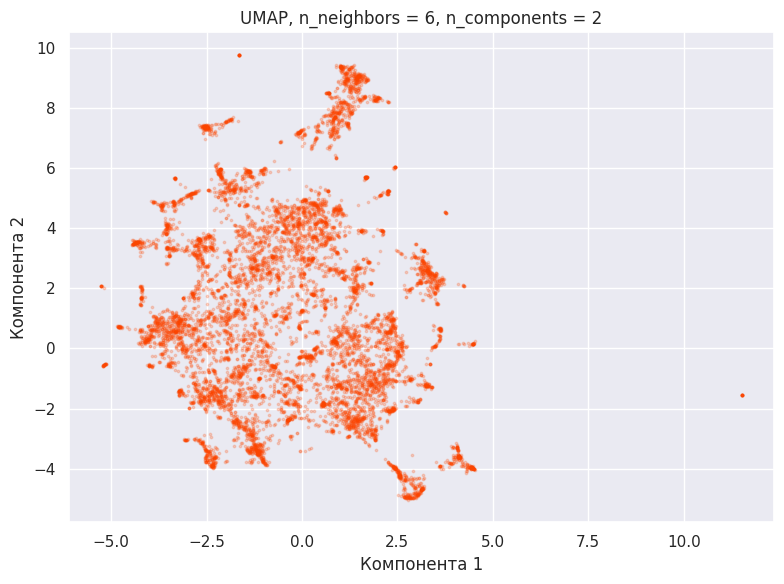

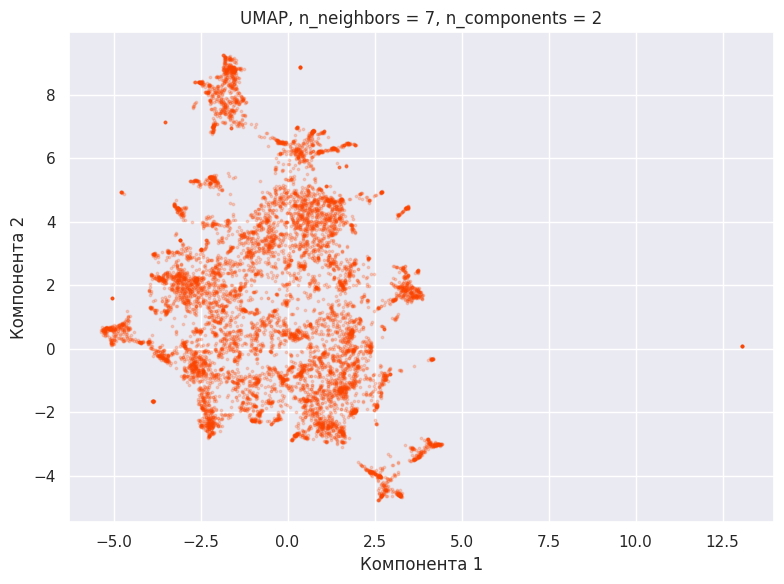

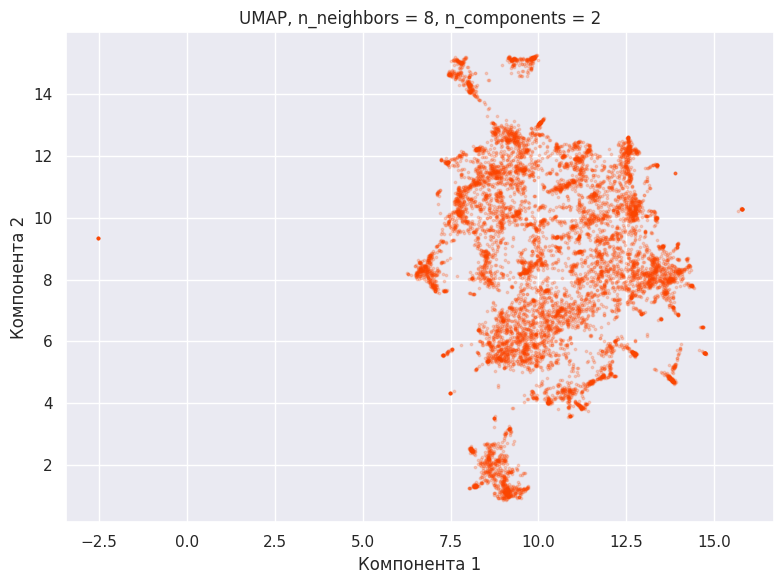

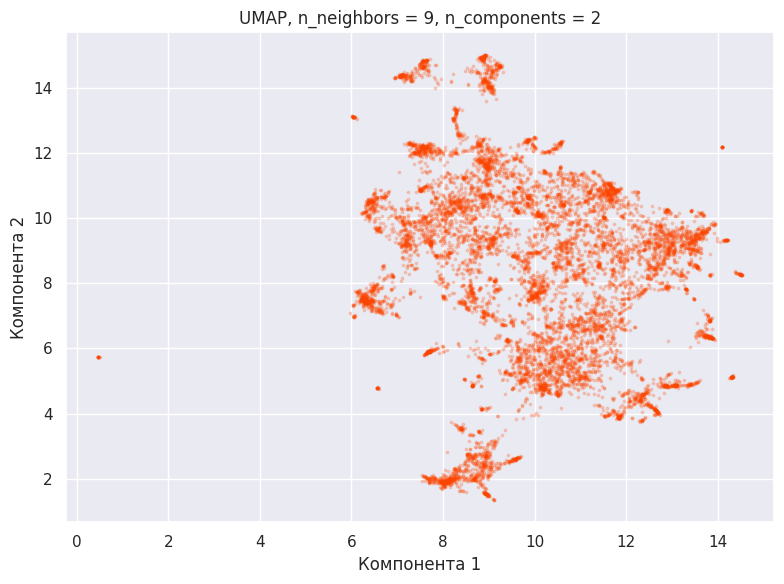

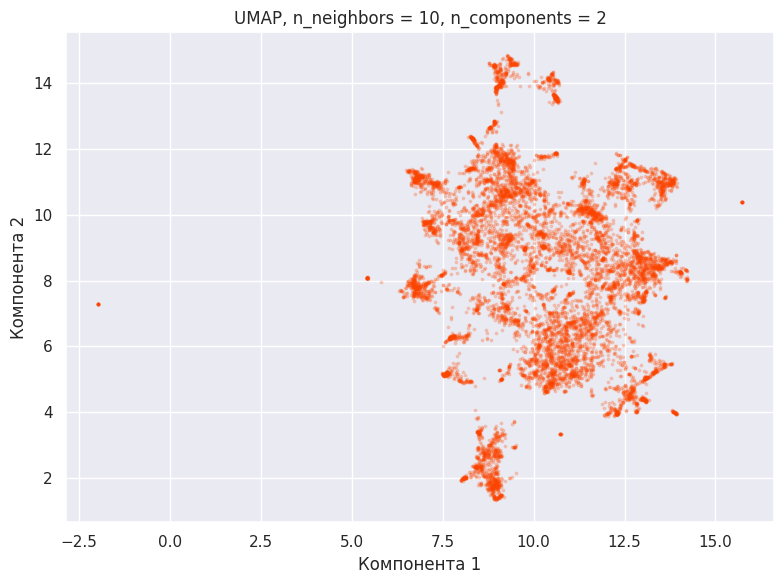

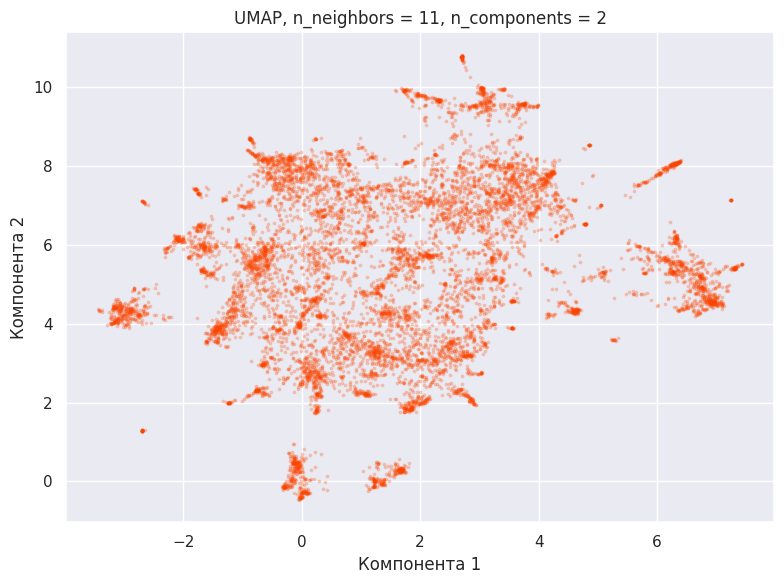

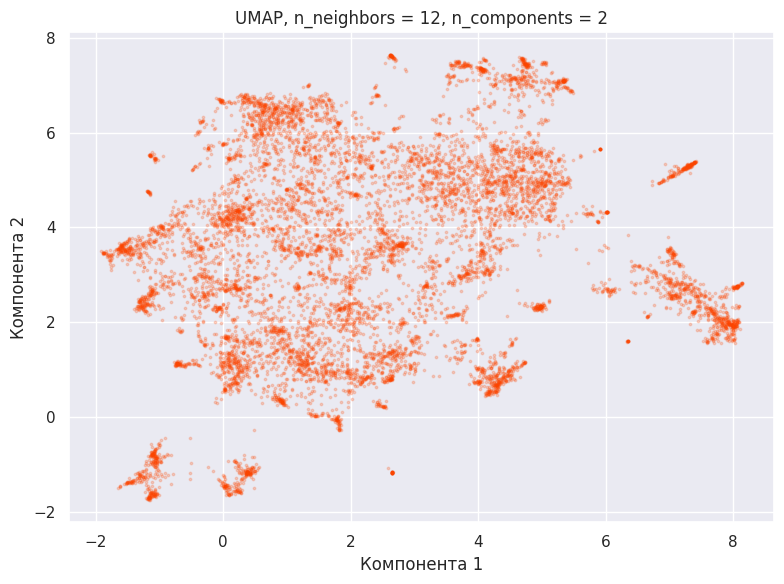

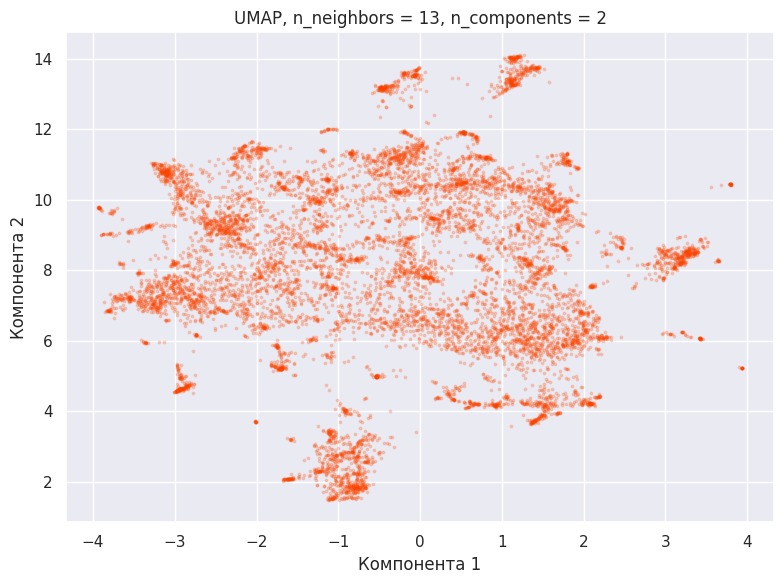

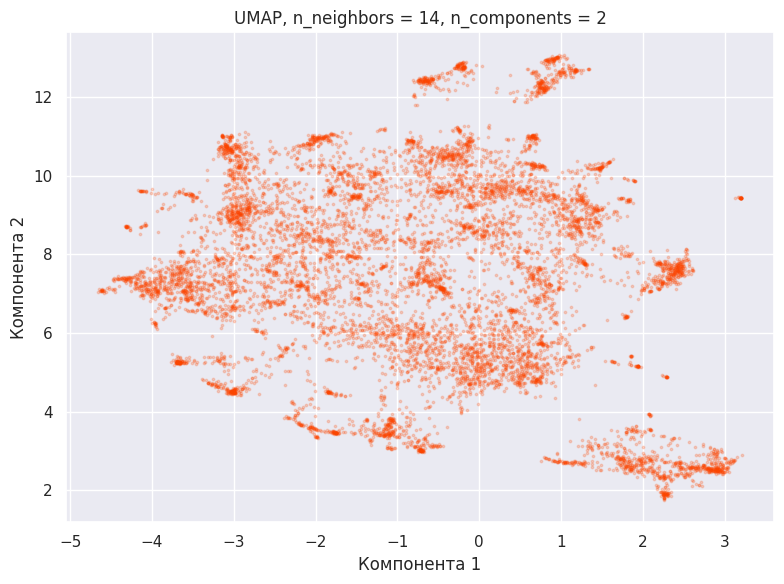

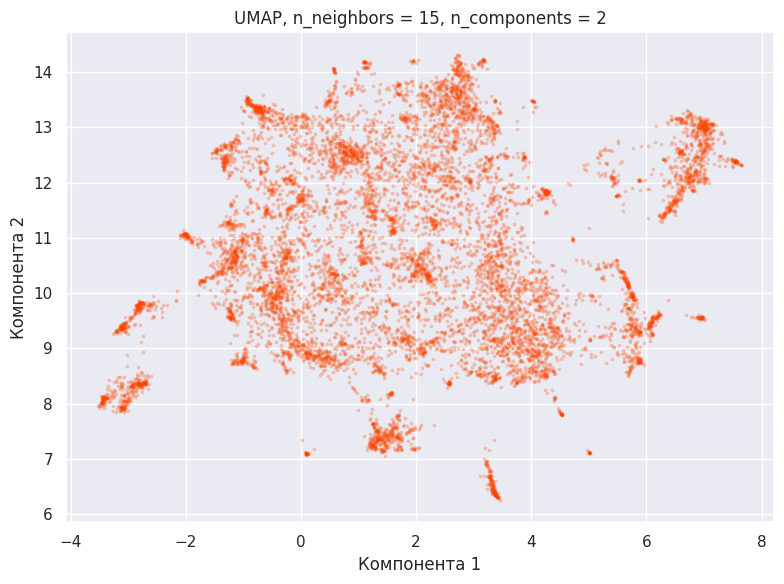

In [25]:
neighbors_list = np.arange(5, 16, 1)
for neighbors in neighbors_list:
    umap_model = UMAP(
        n_neighbors=neighbors,
        n_components=2,
        min_dist=0.0,
        low_memory=False,
        metric="cosine",
        random_state=100,
    )

    # Применяем UMAP к данным
    umap_result = umap_model.fit_transform(embeddings)

    # Визуализируем результаты
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.2, c="orangered", s=3)
    plt.title(f"UMAP, n_neighbors = {neighbors}, n_components = 2")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.tight_layout()
    plt.show()

#### Разобьем данные на кластеры с помощью HDBSCAN:

In [26]:
from hdbscan import HDBSCAN

#### Покажем результаты кластеризации:

In [48]:
# Уменьшим размерность с помощью UMAP
umap_model = UMAP(
    n_neighbors=12,
    n_components=2,
    min_dist=0.0,
    low_memory=False,
    metric="cosine",
    random_state=100,
)
umap_result = umap_model.fit_transform(embeddings)

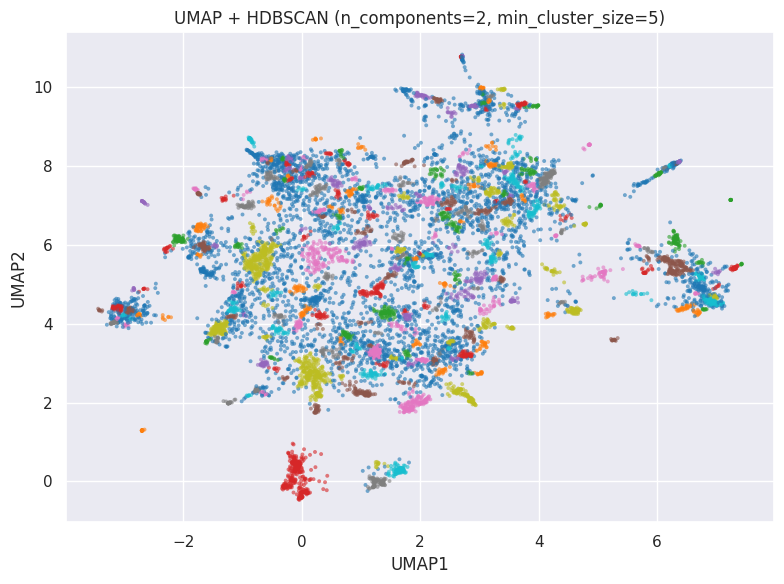

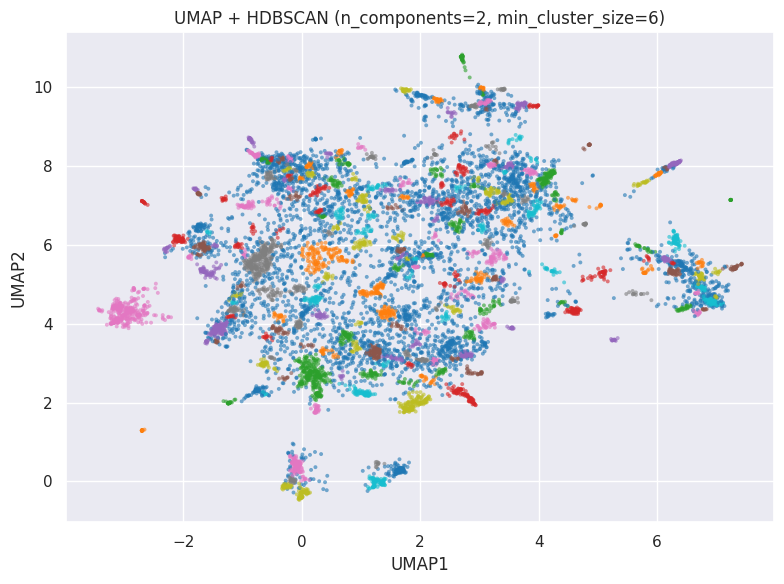

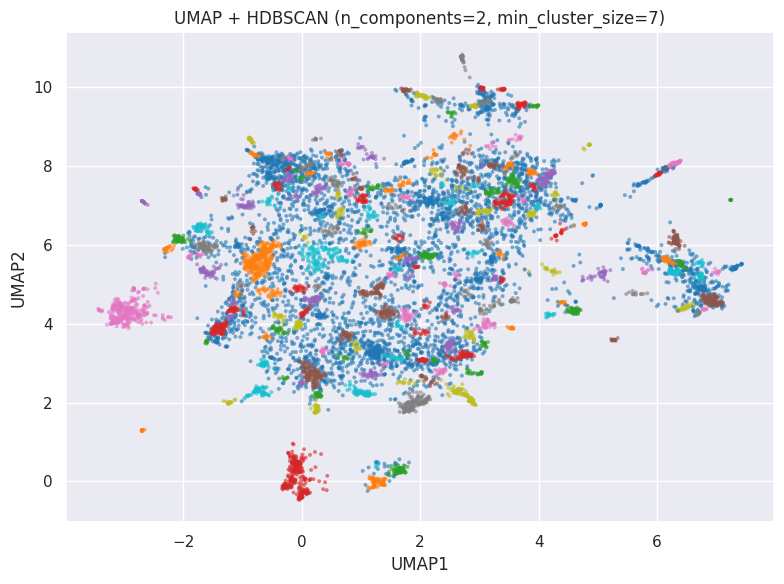

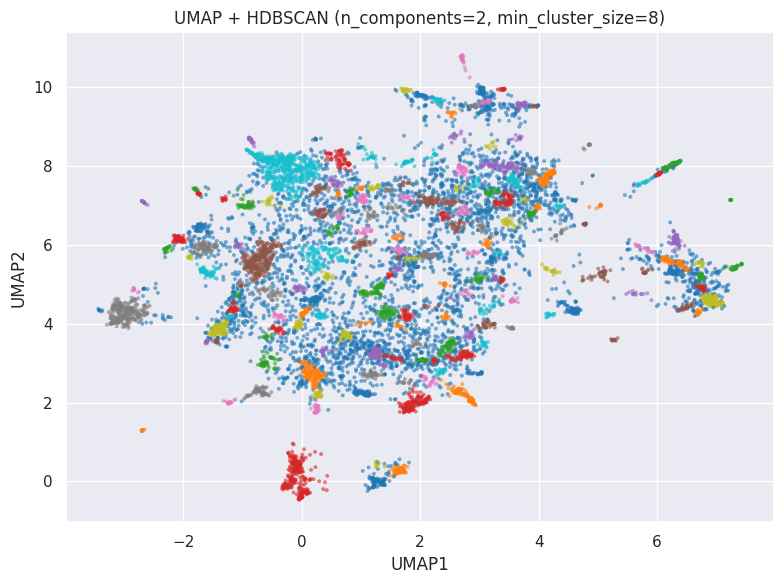

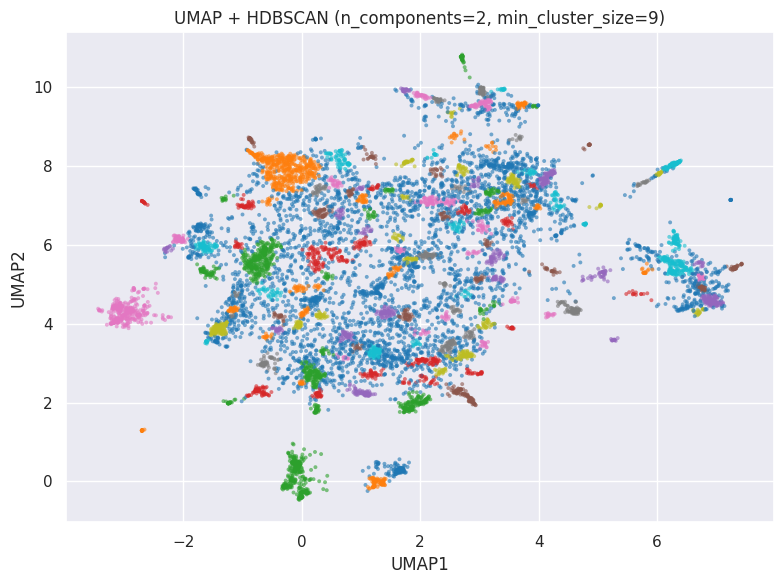

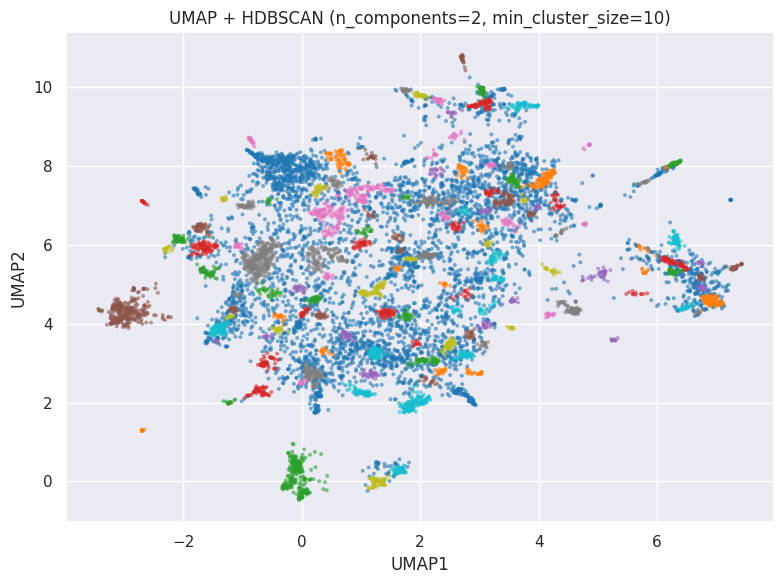

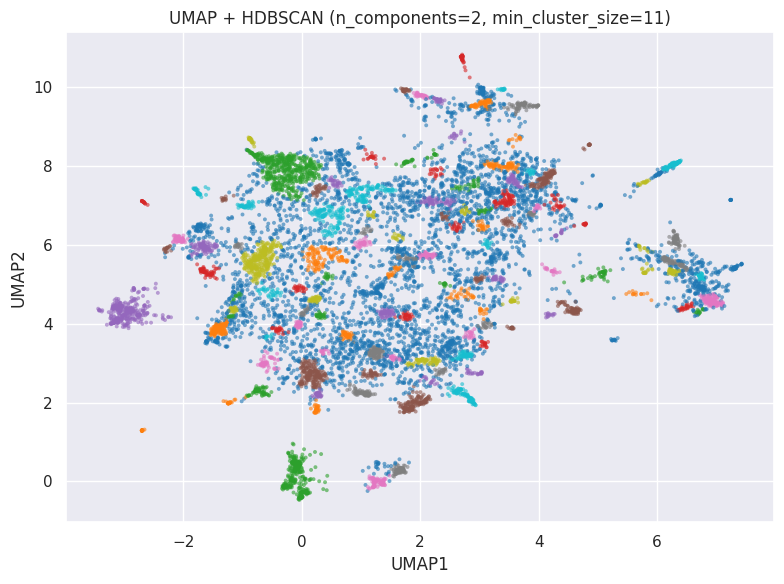

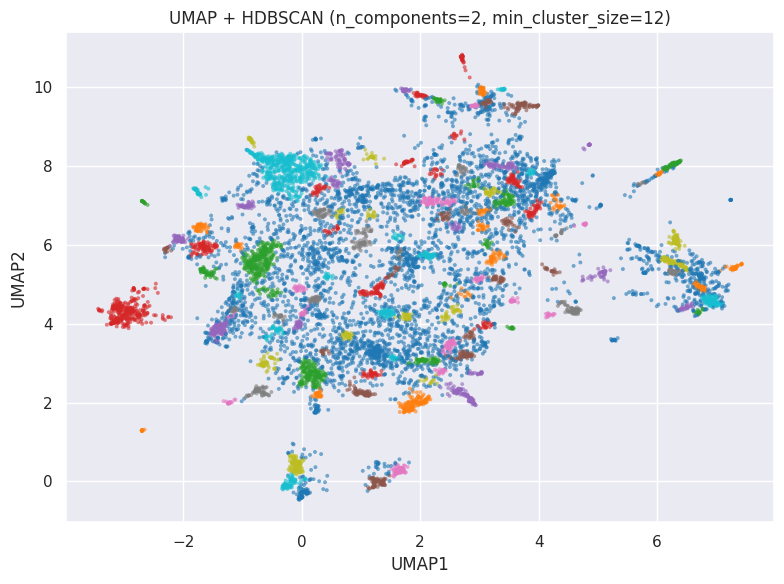

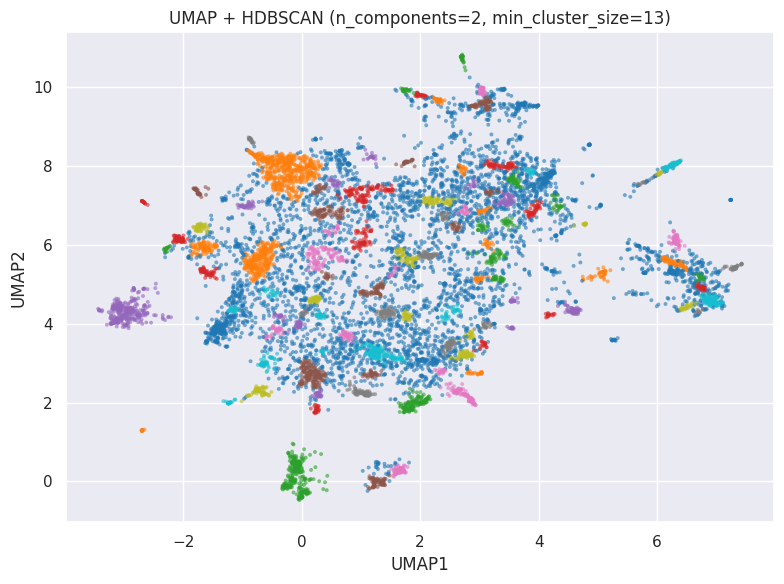

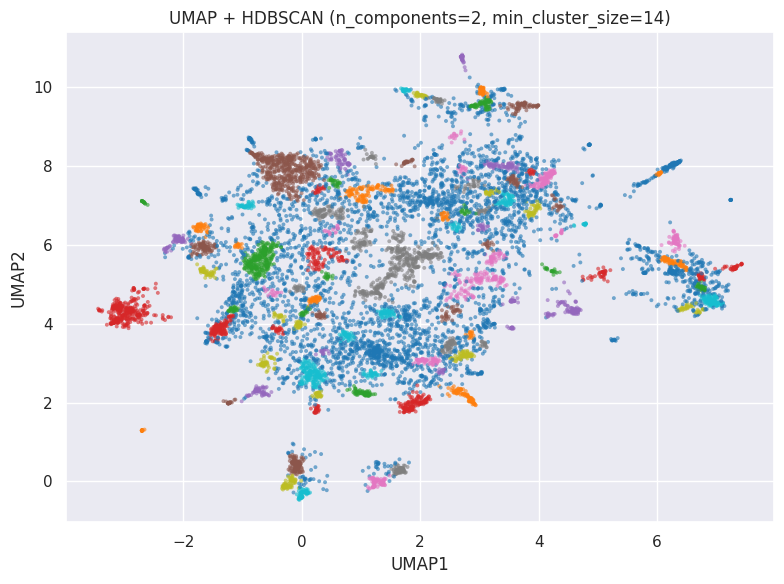

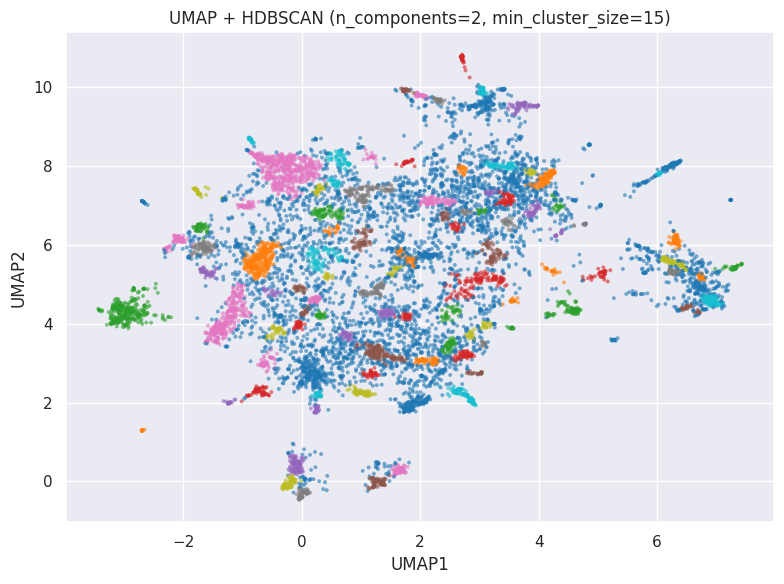

In [49]:
sizes = np.arange(5, 16, 1)
for size in sizes:
    # Кластеризуем данные с помощью HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=size, metric="euclidean", prediction_data=True
    )
    hdbscan_labels = hdbscan_model.fit_predict(umap_result)

    # Создадим DataFrame с результатами UMAP и метками HDBSCAN
    df = pd.DataFrame(umap_result, columns=[f"UMAP{i+1}" for i in range(0, 2, 1)])
    df["Cluster"] = hdbscan_labels

    # Рассеянная диаграмма для результатов UMAP
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="UMAP1",
        alpha=0.6,
        y="UMAP2",
        hue="Cluster",
        data=df,
        palette="tab10",
        legend=None,
        linewidth=0,
        s=8,
    ).set_title(f"UMAP + HDBSCAN (n_components=2, min_cluster_size={size})")
    plt.tight_layout()
    plt.show()

#### Подставим выбранные гипермараметры для UMAP и HDBSCAN:

Гиперпараметры выбраны с учетом целей:
1. Cохранить локальную структуру данных после уменьшения размерности данных, UMAP
2. Уменьшить количество шума в кластерах, HDBSCAN
3. Создать список понятных тем на выходе

In [55]:
umap_model = UMAP(
    n_neighbors=12,
    n_components=5,
    min_dist=0.0,
    low_memory=False,
    metric="cosine",
    random_state=100,
)
hdbscan_model = HDBSCAN(min_cluster_size=11, metric="euclidean", prediction_data=True)

#### Удалим стоп-слова после распределения текстов по темам:

In [30]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(
    stop_words=list(spacy_stopwords), min_df=0.03, max_df=0.99
)

#### Запустим пайплайн и обучим модель:

Модель MaximalMarginalRelevance изменяет порядок слов в темах, чтобы убрать смысловые повторения и составить последовательность из самых значимых слов.

In [56]:
# Создаем модель BERTopic
representation_model = MaximalMarginalRelevance()
topic_model = BERTopic(  # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    language="english",
    verbose=True,
)

# Обучаем модель
topics, probs = topic_model.fit_transform(clean_data, embeddings)

# Получаем темы
topic_representation = topic_model.get_topic_info()

2024-04-12 15:42:47,070 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-12 15:42:56,327 - BERTopic - Dimensionality - Completed ✓
2024-04-12 15:42:56,329 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-12 15:42:56,744 - BERTopic - Cluster - Completed ✓
2024-04-12 15:42:56,751 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-12 15:43:07,718 - BERTopic - Representation - Completed ✓


### Темы:

#### Выведем список тем:

In [57]:
topic_representation["Name"].to_list()

['-1_trump_vote_republicans_biden',
 '0_gun_guns_checks_loophole',
 '1_rural_communities_areas_racist',
 '2_traitor_wishes_objection_treason',
 '3_convention_dnc_democrats_dems',
 '4_israel_iran_war_gaza',
 '5_biden_trump_polls_polling',
 '6_republicans_republican_gop_party',
 '7_putin_russia_ukraine_china',
 '8_court_scotus_judges_judge',
 '9_trump_donald_power_president',
 '10_vote_win_endorse_leader',
 '11_stupid_humans_dumber_morons',
 '12_politicians_politics_vote_democracy',
 '13_eclipse_confused_bizarre_misunderstood',
 '14_cousins_cousin_marriage_family',
 '15_spread_reckless_spreading_criminalize',
 '16_abortion_roe_women_republicans',
 '17_rfk_kennedy_vote_votes',
 '18_stock_doubled_wealth_billionaires',
 '19_god_terrorist_kill_responsible',
 '20_debate_debates_biden_trump',
 '21_laws_bill_act_legislature',
 '22_jail_trial_convicted_guilty',
 '23_pronouns_gender_disrespectful_bob',
 '24_singular_pronouns_unknown_pronoun',
 '25_trump_voting_vote_despise',
 '26_employee_harassm

#### Покажем темы на графиках:

In [58]:
topic_model.visualize_topics()

In [60]:
topic_model.visualize_hierarchy()

#### Создадим датафрейм с данными:

In [36]:
topics_bert = topic_representation["Name"].to_list()

# Получим текущую дату и время
now = datetime.now()
# Преобразуей их в строку в формате YYYYMMDD
date_str = now.strftime("%Y_%m_%d")

df_bert = pd.DataFrame(data=topics_bert, columns=["topics"])
df_bert["date"] = date_str
df_bert["size"] = df_bert.index
df_bert = df_bert[["date", "size", "topics"]]

In [37]:
def clean_df_bert(df):
    df = re.sub(r"-", "", df)
    df = re.sub(r"_", " ", df)
    df = re.sub(r"\b\d+\b", "", df, count=1)
    df = re.sub("^ ", "", df)
    return df

In [38]:
df_bert["topics"] = df_bert["topics"].apply(clean_df_bert)
print(df_bert)

           date  size                                   topics
0    2024_04_12     0             trump vote republicans biden
1    2024_04_12     1                 gun guns checks loophole
2    2024_04_12     2           rural communities areas racist
3    2024_04_12     3         traitor wishes objection treason
4    2024_04_12     4            convention dnc democrats dems
..          ...   ...                                      ...
98   2024_04_12    98             students teacher teachers mr
99   2024_04_12    99  asshole dignity hypocrisy disrespectful
100  2024_04_12   100        election november early headlines
101  2024_04_12   101          story grandma character stories
102  2024_04_12   102            newsweek headline opinion ads

[103 rows x 3 columns]


### Сохраним результат моделирования за день в формате csv:

CSV файлы используем для подстраховки, на случай неисправной работы базы данных.

In [39]:
def save_dataframe(df):
    # Получите текущую дату и время
    now = datetime.now()

    # Преобразуйте их в строку в формате YYYYMMDD
    date_str = now.strftime("%Y_%m_%d")

    # Сохраните DataFrame в CSV-файл с текущей датой в имени файла
    df.to_csv(
        f"/home/bellap/topic_modelling/csvs/{subreddit.display_name}/{subreddit.display_name}_topics_{date_str}.csv",
        index=False,
    )

In [40]:
save_dataframe(df_bert)

## Работа с базой данных SQLite:

Данные каждый день поступают в локальную БД. После накопления достаточного количества данных - можно приступать к новым исследованиям.

### Импорт библиотеки:

In [41]:
import sqlite3

### Наполнение базы данных:

In [42]:
# Создадим подключение к базе данных. Если базы данных не существует, она будет создана.
conn = sqlite3.connect("/home/bellap/topic_modelling/topics_database.db")

In [43]:
# Создадим курсор для выполнения SQL-запросов
c = conn.cursor()

In [44]:
# Преобразуем DataFrame в список кортежей
new_data_tuples = list(df_bert.itertuples(index=False, name=None))

In [45]:
# Обходим новые данные
for row in new_data_tuples:
    # Используем команду INSERT OR REPLACE для обновления существующих строк или вставки новых
    c.execute(
        f"""
        INSERT OR REPLACE INTO {subreddit.display_name} (date, size, topics)
        VALUES (?, ?, ?)
    """,
        row,
    )

In [46]:
# Выбор и вывод содержимого конкретной таблицы
c.execute(f"SELECT * FROM {subreddit.display_name}")
print(c.fetchall())

[('2024_04_05', '0', ' trump biden vote election'), ('2024_04_05', '1', 'israel aid gaza hamas'), ('2024_04_05', '2', 'judge jury trial court'), ('2024_04_05', '3', 'lol thanks comment shit'), ('2024_04_05', '4', 'polls vote polling voting'), ('2024_04_05', '5', 'economy inflation workforce taxes'), ('2024_04_05', '6', 'russian russia putin propaganda'), ('2024_04_05', '7', 'biden trump vote joe'), ('2024_04_05', '8', 'news newsweek fox article'), ('2024_04_05', '9', 'stock shares djt sell'), ('2024_04_05', '10', 'cruz texas ted texans'), ('2024_04_05', '11', 'signs flags flag sign'), ('2024_04_05', '12', 'states electoral votes district'), ('2024_04_05', '13', 'republicans republican conservative gop'), ('2024_04_05', '14', 'trump election supporters loses'), ('2024_04_05', '15', 'religion science theories religious'), ('2024_04_05', '16', 'bread grocery aldi shopping'), ('2024_04_05', '17', 'touches beard touch touched'), ('2024_04_05', '18', 'maga cult trump idiots'), ('2024_04_05',

In [47]:
# Фиксируем изменения и закрываем соединение
conn.commit()
conn.close()